# SVM Ranking Demo
* This demo is a simulation. Imagine a list of N items [1, 2, 3, ... , N] which we know the ground truth ranking for.
* Each item is simply ranked by its index or number.
* Now lets randomly show an SVC a subset of all possible comparisons and let the SVC guess the rankings.
* How good is the generated ranking?

# Generate Data 

In [536]:
import random as rnd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1951]:
N   = 200          # Item count
PR  = 5           # Comparisons per item
NOS = 0.1          # Noise ratio
CPP = 2            # Comparison per pair
TOT = N * PR * CPP # Total # of pairs

In [1952]:
# Generate all possible unique pairs and then subsample
def gen_pairs():
    # Generate all n * ( n - 1 ) / 2
    poss_pairs = [(x, y) for x in range(N) for \
                             y in range(N) if x < y]

    # Sample N * PR (items * pairs_per_item) from the total
    pairs = rnd.sample(poss_pairs, N * PR) * CPP
    pairs = np.array(pairs)

    return pairs

pairs = gen_pairs()
pairs[:5]

array([[ 86, 198],
       [172, 184],
       [ 84, 162],
       [140, 182],
       [ 95, 131]])

# Convert to One-hot

In [1953]:
# One-hot encoding

def one_hot(pairs):
    # Function to one-hot encode pairs:
    # (0, 3) => [1, 0, 0 ,0] - [0, 0, 0, 1] = [1, 0, 0, -1]
    idy = np.identity(N)
    vectorise = lambda x:idy[x[0]] - idy[x[1]]

    # Encode
    X = np.array(list(map(vectorise, pairs)))
    
    return X

X = one_hot(pairs)
X[:5]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [539]:
X.shape

(3000, 200)

# Add Noise

In [1954]:
def add_noise():
    # Add noise
    y = [1 if (rnd.random() > NOS) else -1 for i in range(TOT)]
    y = np.array(y).reshape(TOT, 1)

    return y

y = add_noise()
y[:20]

array([[ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [ 1]])

In [1296]:
y.shape

(4000, 1)

# Balance Class Labels

In [1955]:
def balance_class_labels(X, y):
    # Balance class labels by randomly flipping comparison direction
    flip = [1 if (rnd.random() > 0.5) else -1 for i in range(TOT)]
    flip = np.array(flip).reshape(TOT, 1)

    # Flip the pairs
    X = np.multiply(flip, X)
    y = np.multiply(flip, y)
    
    return X, y

X, y = balance_class_labels(X,y)

X[:5]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

# Rank using SVC

In [532]:
from sklearn.svm import LinearSVC

In [1956]:
def SVC_rank(X, Y):
    cls = LinearSVC()
    model = cls.fit(X, Y)
    
    res = model.coef_
    ranks = np.flip(np.argsort(res), axis=1)
    
    return ranks

In [1957]:
l = SVC_rank(X, y)[0]
l

/Users/nhalabi/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([  6,  11,  17,  24,   9,  43,   4,  23,  33,  15,  50,   8,  44,
         3,   7,  32,  14,   2,  54,   5,  21,  10,  25,  19,  13,  20,
        12,  48,  30,  86,  62,  52,  45,   0,  42,   1,  29,  49,  37,
        55,  26,  22,  16,  40,  28,  46, 110,  58,  84,  63,  67,  38,
        34,  72,  18,  47,  31,  59,  56, 124,  80,  73, 101,  27,  64,
        77,  51,  94,  66,  98,  60,  75,  85,  89,  70,  36, 104,  83,
        68,  35,  41, 108,  79, 109,  96,  97,  82,  74,  78,  88,  57,
       100, 115,  65,  76,  91, 122,  92,  53,  93,  81,  87,  90,  61,
       118, 112,  39, 111, 107, 106, 137,  69,  71,  95, 127,  99, 147,
       128, 143, 103, 135, 105, 188, 139, 121, 145, 148, 125, 172, 129,
       144, 149, 113, 136, 116, 114, 134, 126, 123, 160, 102, 152, 150,
       141, 130, 132, 140, 153, 154, 176, 131, 142, 159, 146, 195, 162,
       138, 168, 156, 120, 169, 119, 166, 117, 151, 174, 192, 171, 157,
       158, 163, 197, 180, 184, 198, 133, 177, 187, 170, 164, 18

In [1958]:
from scipy.stats import spearmanr
spearmanr(SVC_rank(X, y)[0], range(N))

/Users/nhalabi/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SpearmanrResult(correlation=0.92904672616815442, pvalue=1.9049401377886912e-87)

# How reliable appen data is when comparing ranks

In [1959]:
n = 100
ress = [list() for i in range(n)]

for k in range(n):
    pairs = gen_pairs()
    y = add_noise()
    X = one_hot(pairs)
    X, y = balance_class_labels(X, y)
    l = SVC_rank(X, y)[0]
    
    for i in [1] + list(range(5, 101, 5)):
        s = 0
        f = 0
        for j in range(100):
            r1 = rand.randint(0, len(l) - i - 1)
            r2 = r1 + i

            if l[r1] < l[r2]:
                s += 1
            else:
                f += 1

        ress[k].append(s / (s + f))

/Users/nhalabi/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


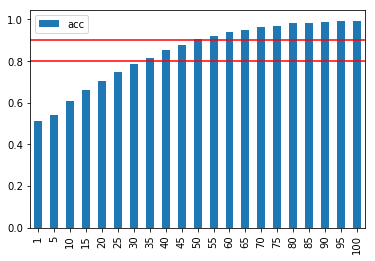

In [1960]:
totals = [sum([l[i] for l in ress]) / n for i in range(len(ress[0]))]

ax = pd.DataFrame({
    'acc': totals
}, index=[1] + list(range(5, 101, 5))).plot(kind='bar')

ax.axhline(0.8, color='r')
ax.axhline(0.9, color='r')

plt.show()

# Expected disagreement with expert (trivago peeps)

In [1961]:
ress = []
s, f = 0, 0

for i in range(1000):
    for p1, p2 in gen_pairs():
        p11 = p1
        p22 = p2
        if rand.random() < 0.21:
            if rand.random() < 0.5:
                p11, p22 = p2, p1

        if l[p11] < l[p22]:
            s += 1
        else:
            f += 1
        p11 = p1
        p22 = p2
        if rand.random() < 0.21:
            if rand.random() < 0.5:
                p11, p22 = p2, p1

        if l[p11] < l[p22]:
            s += 1
        else:
            f += 1

    ress.append(s / (s + f))
    
np.mean(ress)

0.78875189930383194

# Noise/Disagreement simulation

In [1974]:
# Trivago/Appen disagreement and error rates (also adj disagreement)
t = 10000
s = 0
noises = [0.21, 0.2, 0.3]

for noise in noises:
    s = 0
    for i in range(t):
        r1 = rand.random() > noise
        r2 = rand.random() > noise

        if not r1:
            r1 = rand.random() > 0.5
        if not r2:
            r2 = rand.random() > 0.5

        s += int(r1 == r2)
    
    print(s / t)

0.8173
0.8129
0.7502


# Till when can we trust Appen

In [1735]:
corr_w_re = []
corr_w_gt = []
NOS = 0.11
for PR in range(1, 95, 1):
    TOT = N * PR * CPP
    pairs = gen_pairs()
    y = add_noise()
    X = one_hot(pairs)
    X, y = balance_class_labels(X, y)
    temp = SVC_rank(X, y)

    corr_w_re.append(spearmanr(temp[0], range(N))[0])
    corr_w_gt.append(spearmanr(temp[0], l))

/Users/nhalabi/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


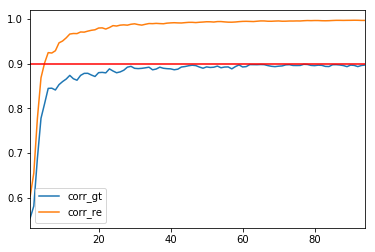

In [1750]:
corr_w_gt_s = []
corr_w_re_s = []
for i in range(len(corr_w_gt)):
    lb = max(0, i - 1)
    ub = min(len(corr_w_gt) - 1, i + 1)
    
    corr_w_gt_s.append(np.mean(corr_w_gt[lb:ub]))
    corr_w_re_s.append(np.mean(corr_w_re[lb:ub]))

ax = pd.DataFrame({
    'corr_gt': corr_w_gt_s,
    'corr_re': corr_w_re_s
}, index=range(1, 95, 1)).plot(kind='line')
ax.axhline(0.9, color='r')
plt.show()


# Motivation
* The applications (Recommender systems and IR).
* System comparison (Can we do statistical significance?).
* The simulation can be improved by better choice of pairs as the comparisons results are being produced.

# Demotivation
* Does not scale well. The are ways to make it scale for larger items and other methods which sacrafice quality for speed.